In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy import ndimage
import pandas as pd

from tensorflow.keras import models, layers, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import LeakyReLU

import os

In [29]:
base_dir='../data/chest_xray/'

train_path = '../data/chest_xray/train'

validation_path = '../data/chest_xray/val'

test_path = '../data/chest_xray/test'

full_train_path = '../data/chest_xray/full_train'

In [30]:
train_pneumonia=os.listdir('../data/chest_xray/train/PNEUMONIA/')
train_normal=os.listdir('../data/chest_xray/train/NORMAL/')
val_dir_normal=os.listdir('../data/chest_xray/val/NORMAL/')
test_dir_normal=os.listdir('../data/chest_xray/test/NORMAL/')
val_dir_pneumonia=os.listdir('../data/chest_xray/val/PNEUMONIA/')
test_dir_pneumonia=os.listdir('../data/chest_xray/test/PNEUMONIA/')


##trying out combining training and validation sets and using a validation ratio when fitting models
full_train_pneumonia = os.listdir('../data/chest_xray/full_train/PNEUMONIA')
full_train_normal = os.listdir('../data/chest_xray/full_train/NORMAL')


##list object containing 'NORMAL' & 'PNEUMONIA'
label_string = os.listdir('../data/chest_xray/train')

In [31]:
# Greyscale distribution histogram - done, Jamie
# Class distribution - heavily weighted towards positive class (pneumonia) - done, Jamie
# Address class imbalance - incorporate flipped 0-class images - Rachel wrote a function for this
# Mean values for negative and positive classes - Svitlana 
# Look for outliers
# Look at subracting the pixel mean
# Apply matrix transformations to further define images - 
# Data Augmentation - Svitlana will make an attempt

In [32]:
print("Train set w/ pneumonia: ", len(train_pneumonia))
print("Train set normal: ", len(train_normal))
print("Validation set w/ pneumonia: ", len(val_dir_pneumonia))
print("Validation set normal: ", len(val_dir_normal))
print("Test set w/ pneumonia: ", len(test_dir_pneumonia))
print("Test set normal: ", len(test_dir_normal))
print("Full training set w/pneumonia (combined w/validation): ", len(full_train_pneumonia))
print("Full training set normal (combined w/validation): ", len(full_train_normal))

Train set w/ pneumonia:  2144
Train set normal:  699
Validation set w/ pneumonia:  1739
Validation set normal:  650
Test set w/ pneumonia:  390
Test set normal:  234
Full training set w/pneumonia (combined w/validation):  3883
Full training set normal (combined w/validation):  1349


In [33]:
2144+699, 1739+650, 390+234, 3883+1349

(2843, 2389, 624, 5232)

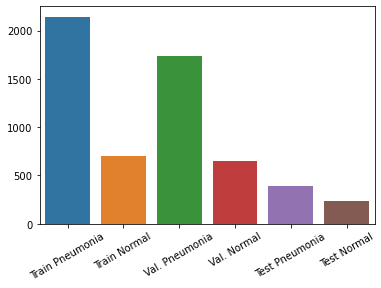

In [34]:
labels = ['Train Pneumonia', 'Train Normal', 'Val. Pneumonia', 'Val. Normal', 'Test Pneumonia', 'Test Normal']
dist = sns.barplot(x=labels, 
           y=[len(train_pneumonia), len(train_normal), len(val_dir_pneumonia), len(val_dir_normal), len(test_dir_pneumonia), len(test_dir_normal)],)

dist.set_xticklabels(labels = labels, rotation = 30);

In [62]:
#loading images for training set - pneumonia

plt.suptitle("Patients with Pneumonia")
for i in range(0,4):
    img = train_pneumonia[i]
    img = load_img(train_path+'/PNEUMONIA/'+img)
#   plt.imshow(img)
#   plt.show()

<Figure size 432x288 with 0 Axes>

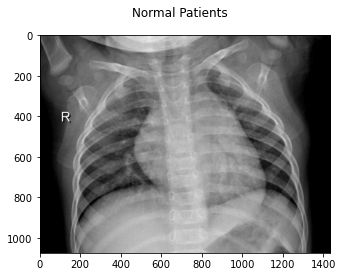

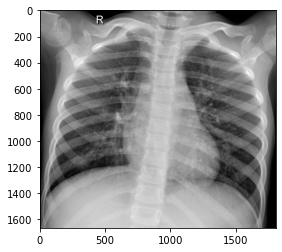

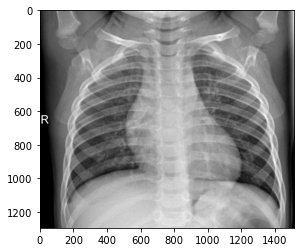

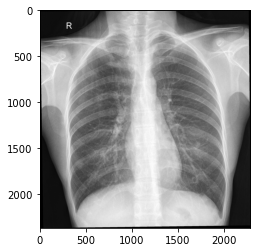

In [64]:
#loading images for training set - normal

plt.suptitle("Normal Patients")
for i in range(0,4):
    img = train_normal[i]
    img = load_img(train_path+'/NORMAL/'+img)
    plt.imshow(img)
    plt.show()

In [37]:
train_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=2843,
                                                 color_mode = 'grayscale',                
                                                 class_mode='binary')

val_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(validation_path,
                                            target_size=(224, 224),
                                            shuffle=True,
                                            batch_size=2389,
                                            color_mode = 'grayscale',                      
                                            class_mode='binary')

test_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(test_path,
                                            target_size=(224, 224),
                                            batch_size=624,
                                            color_mode = 'grayscale',                        
                                            class_mode='binary')

##Image generator object for full training folder
full_train_gen = ImageDataGenerator(rescale = 1/255.).flow_from_directory(full_train_path,
                                            target_size=(224, 224),
                                            batch_size=5232,
                                            color_mode = 'grayscale',                        
                                            class_mode='binary')

Found 2843 images belonging to 2 classes.
Found 2389 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [38]:
train_images, train_labels = next(train_gen)
val_images, val_labels = next(val_gen)
test_images, test_labels = next(test_gen)

##full training folder
full_train_images, full_train_labels = next(full_train_gen)

In [39]:
print("Train image shape:", train_images.shape, "train label shape:", train_labels.shape)
print("Val image shape:", val_images.shape, "val label shape:", val_labels.shape)
print("Test image shape:", test_images.shape, "test label shape:", test_labels.shape)

print("Full Train image shape:", full_train_images.shape, "full train label shape:", full_train_labels.shape)

Train image shape: (2843, 224, 224, 1) train label shape: (2843,)
Val image shape: (2389, 224, 224, 1) val label shape: (2389,)
Test image shape: (624, 224, 224, 1) test label shape: (624,)
Full Train image shape: (5232, 224, 224, 1) full train label shape: (5232,)


In [40]:
train_x = train_images.reshape(train_images.shape[0], -1)
val_x = val_images.reshape(val_images.shape[0], -1)
test_x = test_images.reshape(test_images.shape[0], -1)

full_train_x = full_train_images.reshape(full_train_images.shape[0], -1)

In [41]:
train_x.shape, val_x.shape, test_x.shape, full_train_x.shape

((2843, 50176), (2389, 50176), (624, 50176), (5232, 50176))

In [42]:
train_y = np.reshape(train_labels[:], (2843,1))
val_y = np.reshape(val_labels[:], (2389,1))
test_y = np.reshape(test_labels[:], (624,1))

##full training set labels
full_train_y = np.reshape(full_train_labels[:], (5232,1))

In [43]:
train_y.shape, val_y.shape, test_y.shape, full_train_y.shape

((2843, 1), (2389, 1), (624, 1), (5232, 1))

# FSM  
### using one hidden layer

In [44]:
np.random.seed(42)


model = models.Sequential()
model.add(layers.Dense(12, activation='relu', input_shape=(50176,)))
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [45]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics= (['accuracy'], metrics.Recall()))

history = model.fit(train_x,
                    train_y,
                    epochs=25,
                    batch_size=32,
                    validation_data=(val_x, val_y))

Epoch 1/25
89/89 [==============================] - 1s 13ms/step - loss: 0.9788 - accuracy: 0.7408 - recall_1: 0.9688 - val_loss: 0.4538 - val_accuracy: 0.7279 - val_recall_1: 1.0000
Epoch 2/25
89/89 [==============================] - 1s 10ms/step - loss: 0.3683 - accuracy: 0.8491 - recall_1: 0.9501 - val_loss: 0.3420 - val_accuracy: 0.8870 - val_recall_1: 0.9454
Epoch 3/25
89/89 [==============================] - 1s 10ms/step - loss: 0.3295 - accuracy: 0.8832 - recall_1: 0.9403 - val_loss: 0.3148 - val_accuracy: 0.8899 - val_recall_1: 0.9753
Epoch 4/25
89/89 [==============================] - 1s 10ms/step - loss: 0.3032 - accuracy: 0.8980 - recall_1: 0.9412 - val_loss: 0.2969 - val_accuracy: 0.9138 - val_recall_1: 0.9235
Epoch 5/25
89/89 [==============================] - 1s 10ms/step - loss: 0.2844 - accuracy: 0.9082 - recall_1: 0.9431 - val_loss: 0.3986 - val_accuracy: 0.8451 - val_recall_1: 0.9948
Epoch 6/25
89/89 [==============================] - 1s 10ms/step - loss: 0.2754 - acc

# First CNN 

In [46]:
batch_size = 64
epochs = 10
num_classes = 2

In [47]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224 , 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))

In [48]:
model.compile(optimizer = 'rmsprop', 
              loss = 'binary_crossentropy', 
              metrics = (['accuracy'], metrics.Recall()))

In [23]:
history = model.fit(train_images, train_y, epochs = epochs, batch_size = batch_size, validation_data=(val_images, val_y))

Epoch 1/10
45/45 [==============================] - 104s 2s/step - loss: 0.8359 - accuracy: 0.7323 - recall_2: 0.8965 - val_loss: 0.3964 - val_accuracy: 0.8121 - val_recall_2: 0.9741
Epoch 2/10
45/45 [==============================] - 104s 2s/step - loss: 0.2661 - accuracy: 0.8969 - recall_2: 0.9389 - val_loss: 0.2164 - val_accuracy: 0.9075 - val_recall_2: 0.9293
Epoch 3/10
45/45 [==============================] - 104s 2s/step - loss: 0.1898 - accuracy: 0.9275 - recall_2: 0.9492 - val_loss: 0.2034 - val_accuracy: 0.9171 - val_recall_2: 0.9862
Epoch 4/10
45/45 [==============================] - 103s 2s/step - loss: 0.1266 - accuracy: 0.9525 - recall_2: 0.9660 - val_loss: 0.3004 - val_accuracy: 0.8887 - val_recall_2: 0.9931
Epoch 5/10
45/45 [==============================] - 103s 2s/step - loss: 0.1221 - accuracy: 0.9592 - recall_2: 0.9734 - val_loss: 0.2082 - val_accuracy: 0.9234 - val_recall_2: 0.9862
Epoch 6/10
45/45 [==============================] - 103s 2s/step - loss: 0.0953 - acc

In [24]:
results_train = model.evaluate(train_images, train_y)

89/89 [==============================] - 15s 164ms/step - loss: 0.0266 - accuracy: 0.9912 - recall_2: 0.9911


In [25]:
history.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x2c9811a6f10>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.8359042406082153,
   0.26605403423309326,
   0.1898120790719986,
   0.1265503466129303,
   0.12214074283838272,
   0.0952768325805664,
   0.0923868864774704,
   0.07239553332328796,
   0.04858693480491638,
   0.057141952216625214],
  'accuracy': [0.73232501745224,
   0.8969398736953735,
   0.9275413155555725,
   0.9525149464607239,
   0.9591980576515198,
   0.9655293822288513,
   0.9690467715263367,
   0.9739711284637451,
   0.9834681749343872,
   0.9810059666633606],
  'recall_2': [0.8964552283287048,
   0.9388992786407471,
   0.9491604566574097,
   0.9659515023231506,
   0.9734141826629639,
   0.9776119589805603,
   0.9762126803398132,
   0.9808768630027771,
   0.9883395433425903,
   0.9878731369972229],
  'val_loss': [0.39636850357055664,
   0.21642054617404938,
   0.20339012145996094,
   0.3004

In [26]:
model_epochs = history.epoch
model_recall_train = history.history['recall_2']
model_recall_val = history.history['val_recall_2']
model_accuracy_train = history.history['accuracy']
model_accuracy_val = history.history['val_accuracy']

## Plotting Accuracy and Recall Against Epochs

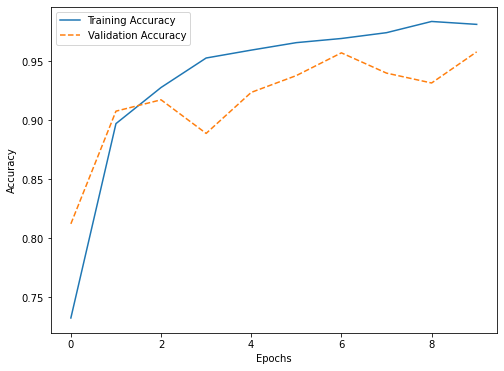

In [27]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs, model_accuracy_train, label = 'Training Accuracy')
ax.plot(model_epochs, model_accuracy_val, linestyle = '--', label = 'Validation Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.legend();

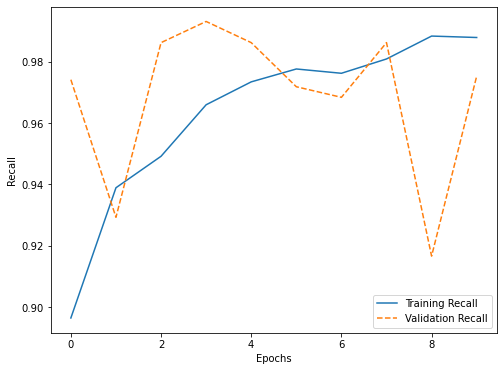

In [28]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs, model_recall_train, label = 'Training Recall')
ax.plot(model_epochs, model_recall_val, linestyle = '--', label = 'Validation Recall')
ax.set_xlabel("Epochs")
ax.set_ylabel("Recall")
plt.legend();

## Second CNN

In [49]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (5, 5), activation='relu',
                        input_shape=(224 , 224, 1)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(32, (4, 4), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model2.add(LeakyReLU())
model2.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))

In [30]:
history2 = model2.fit(train_images, train_y, epochs = epochs, batch_size = batch_size, validation_data=(val_images, val_y))

Epoch 1/10
45/45 [==============================] - 108s 2s/step - loss: 0.4900 - accuracy: 0.8206 - recall_3: 0.9473 - val_loss: 0.2965 - val_accuracy: 0.8761 - val_recall_3: 0.9321
Epoch 2/10
45/45 [==============================] - 109s 2s/step - loss: 0.2178 - accuracy: 0.9173 - recall_3: 0.9529 - val_loss: 0.1806 - val_accuracy: 0.9364 - val_recall_3: 0.9373
Epoch 3/10
45/45 [==============================] - 109s 2s/step - loss: 0.1518 - accuracy: 0.9402 - recall_3: 0.9604 - val_loss: 0.2501 - val_accuracy: 0.9025 - val_recall_3: 0.9942
Epoch 4/10
45/45 [==============================] - 110s 2s/step - loss: 0.1697 - accuracy: 0.9455 - recall_3: 0.9646 - val_loss: 0.1355 - val_accuracy: 0.9514 - val_recall_3: 0.9827
Epoch 5/10
45/45 [==============================] - 113s 3s/step - loss: 0.0977 - accuracy: 0.9617 - recall_3: 0.9757 - val_loss: 0.1412 - val_accuracy: 0.9514 - val_recall_3: 0.9442
Epoch 6/10
45/45 [==============================] - 107s 2s/step - loss: 0.0827 - acc

In [31]:
results_train2 = model2.evaluate(train_images, train_y)

89/89 [==============================] - 21s 234ms/step - loss: 0.0327 - accuracy: 0.9905 - recall_3: 0.9967


## Third CNN

In [50]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (8, 8), activation='relu',
                        input_shape=(224 , 224, 1)))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(32, (4, 4), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model3.add(LeakyReLU())
model3.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model3.add(Dropout(.5))
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))

In [33]:
history3 = model3.fit(train_images, train_y, epochs = epochs, batch_size = batch_size, validation_data=(val_images, val_y))

Epoch 1/10
45/45 [==============================] - 124s 3s/step - loss: 0.6452 - accuracy: 0.7341 - recall_4: 0.9683 - val_loss: 0.4265 - val_accuracy: 0.7279 - val_recall_4: 1.0000
Epoch 2/10
45/45 [==============================] - 121s 3s/step - loss: 0.3857 - accuracy: 0.8087 - recall_4: 0.9921 - val_loss: 0.5421 - val_accuracy: 0.8786 - val_recall_4: 0.9051
Epoch 3/10
45/45 [==============================] - 122s 3s/step - loss: 0.3494 - accuracy: 0.8660 - recall_4: 0.9692 - val_loss: 0.3342 - val_accuracy: 0.8949 - val_recall_4: 0.9632
Epoch 4/10
45/45 [==============================] - 122s 3s/step - loss: 0.2932 - accuracy: 0.9100 - recall_4: 0.9748 - val_loss: 0.2939 - val_accuracy: 0.9142 - val_recall_4: 0.9730
Epoch 5/10
45/45 [==============================] - 118s 3s/step - loss: 0.4337 - accuracy: 0.9212 - recall_4: 0.9748 - val_loss: 0.2656 - val_accuracy: 0.9372 - val_recall_4: 0.9482
Epoch 6/10
45/45 [==============================] - 111s 2s/step - loss: 0.2461 - acc

In [34]:
results_train3 = model3.evaluate(train_images, train_y)

89/89 [==============================] - 17s 195ms/step - loss: 0.0781 - accuracy: 0.9729 - recall_4: 0.9851


In [27]:
#history3.__dict__

In [37]:
model_epochs3 = history3.epoch
model_recall_train3 = history3.history['recall_4']
model_recall_val3 = history3.history['val_recall_4']
model_accuracy_train3 = history3.history['accuracy']
model_accuracy_val3 = history3.history['val_accuracy']

## Plotting CNN3

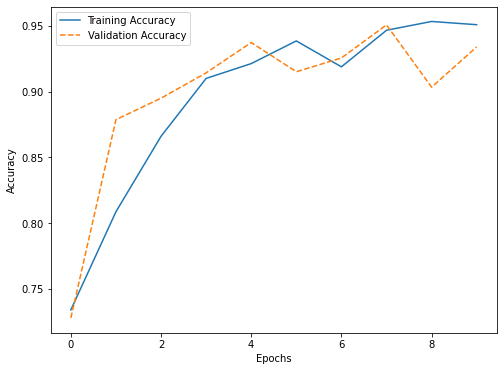

In [38]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs3, model_accuracy_train3, label = 'Training Accuracy')
ax.plot(model_epochs3, model_accuracy_val3, linestyle = '--', label = 'Validation Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.legend();

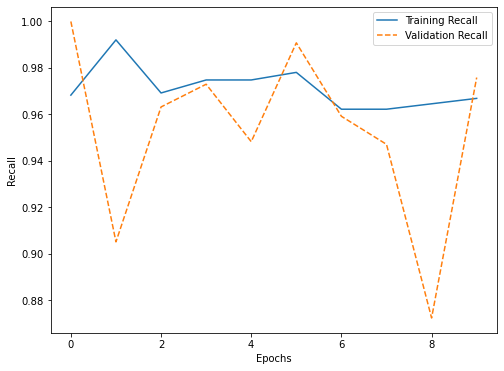

In [39]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs3, model_recall_train3, label = 'Training Recall')
ax.plot(model_epochs3, model_recall_val3, linestyle = '--', label = 'Validation Recall')
ax.set_xlabel("Epochs")
ax.set_ylabel("Recall")
plt.legend();

## Fitting CNN3 on full training set with a validation percentage

In [65]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (8, 8), activation='relu',
                        input_shape=(224 , 224, 1)))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(32, (4, 4), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model3.add(LeakyReLU())
model3.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model3.add(Dropout(.5))
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))

In [66]:
history3 = model3.fit(full_train_images, full_train_y, epochs = 15, batch_size = batch_size, validation_split=.25)

Epoch 1/15
62/62 [==============================] - 154s 2s/step - loss: 0.6722 - accuracy: 0.7350 - recall_7: 0.9713 - val_loss: 0.4238 - val_accuracy: 0.7607 - val_recall_7: 1.0000
Epoch 2/15
62/62 [==============================] - 158s 3s/step - loss: 0.4147 - accuracy: 0.8379 - recall_7: 0.9238 - val_loss: 0.2684 - val_accuracy: 0.9052 - val_recall_7: 0.8864
Epoch 3/15
62/62 [==============================] - 148s 2s/step - loss: 0.2803 - accuracy: 0.8986 - recall_7: 0.9415 - val_loss: 0.1243 - val_accuracy: 0.9541 - val_recall_7: 0.9849
Epoch 4/15
62/62 [==============================] - 147s 2s/step - loss: 0.1763 - accuracy: 0.9317 - recall_7: 0.9550 - val_loss: 0.0944 - val_accuracy: 0.9671 - val_recall_7: 0.9769
Epoch 5/15
62/62 [==============================] - 151s 2s/step - loss: 0.2850 - accuracy: 0.9309 - recall_7: 0.9560 - val_loss: 0.1365 - val_accuracy: 0.9511 - val_recall_7: 0.9819
Epoch 6/15
62/62 [==============================] - 150s 2s/step - loss: 0.1477 - acc

In [97]:
#history3.__dict__

In [68]:
model_epochs3 = history3.epoch
model_recall_train3 = history3.history['recall_7']
model_recall_val3 = history3.history['val_recall_7']
model_accuracy_train3 = history3.history['accuracy']
model_accuracy_val3 = history3.history['val_accuracy']
model_loss_train3 = history3.history['loss']
model_loss_val3 = history3.history['val_loss']

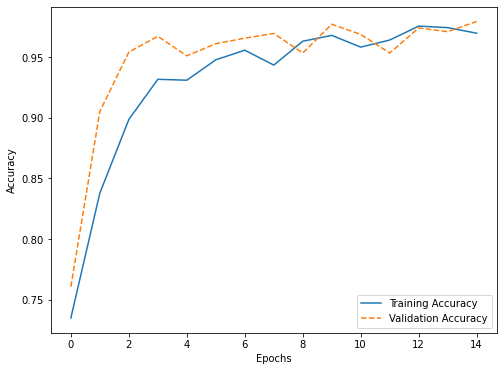

In [69]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs3, model_accuracy_train3, label = 'Training Accuracy')
ax.plot(model_epochs3, model_accuracy_val3, linestyle = '--', label = 'Validation Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.legend();

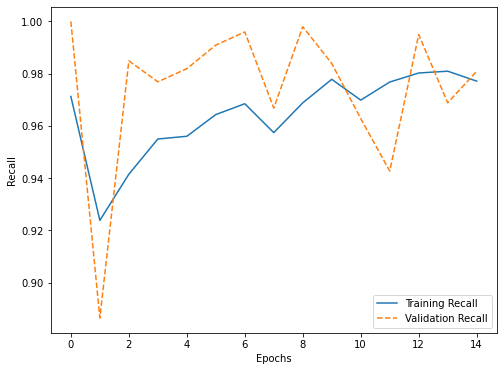

In [70]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs3, model_recall_train3, label = 'Training Recall')
ax.plot(model_epochs3, model_recall_val3, linestyle = '--', label = 'Validation Recall')
ax.set_xlabel("Epochs")
ax.set_ylabel("Recall")
plt.legend();

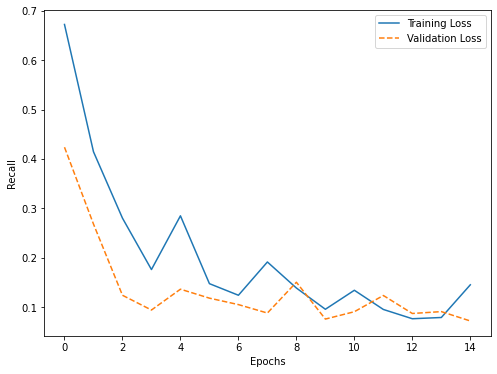

In [71]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(model_epochs3, model_loss_train3, label = 'Training Loss')
ax.plot(model_epochs3, model_loss_val3, linestyle = '--', label = 'Validation Loss')
ax.set_xlabel("Epochs")
ax.set_ylabel("Recall")
plt.legend();

In [72]:
full_results = model3.evaluate(full_train_images, full_train_y)

164/164 [==============================] - 40s 244ms/step - loss: 0.0472 - accuracy: 0.9830 - recall_7: 0.9815


In [86]:
y_preds = model3.predict_generator(full_train_images)
y_pred = np.round(y_preds)

In [91]:
y_pred = y_pred.astype(int)

In [95]:
y_true = full_train_y.astype(int)

In [96]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

confusion_matrix(y_true, y_pred)

array([[1332,   17],
       [  72, 3811]], dtype=int64)

## CNN 4 - further fiddling - tanh activation

In [98]:
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (4, 4), activation='tanh',
                        input_shape=(224 , 224, 1)))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(32, (4, 4), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model4.add(LeakyReLU())
model4.add(layers.MaxPooling2D((2, 2), padding = 'same'))

model4.add(Dropout(.5))
model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=(['accuracy'], metrics.Recall()))

In [99]:
history4 = model4.fit(full_train_images, full_train_y, epochs = 15, batch_size = batch_size, validation_split=.25)

Epoch 1/15
62/62 [==============================] - 115s 2s/step - loss: 0.8980 - accuracy: 0.7362 - recall_8: 0.9404 - val_loss: 0.4169 - val_accuracy: 0.7607 - val_recall_8: 1.0000
Epoch 2/15
62/62 [==============================] - 122s 2s/step - loss: 0.3238 - accuracy: 0.8693 - recall_8: 0.9477 - val_loss: 0.1467 - val_accuracy: 0.9465 - val_recall_8: 0.9628
Epoch 3/15
62/62 [==============================] - 123s 2s/step - loss: 0.2225 - accuracy: 0.9116 - recall_8: 0.9453 - val_loss: 0.1323 - val_accuracy: 0.9648 - val_recall_8: 0.9668
Epoch 4/15
62/62 [==============================] - 122s 2s/step - loss: 0.1581 - accuracy: 0.9434 - recall_8: 0.9671 - val_loss: 0.0845 - val_accuracy: 0.9679 - val_recall_8: 0.9859
Epoch 5/15
62/62 [==============================] - 121s 2s/step - loss: 0.1323 - accuracy: 0.9485 - recall_8: 0.9664 - val_loss: 0.0920 - val_accuracy: 0.9656 - val_recall_8: 0.9608
Epoch 6/15
62/62 [==============================] - 128s 2s/step - loss: 0.1151 - acc

In [100]:
full_results4 = model4.evaluate(full_train_images, full_train_y)

164/164 [==============================] - 44s 267ms/step - loss: 0.0291 - accuracy: 0.9903 - recall_8: 0.9941


In [104]:
y_preds = model4.predict_generator(full_train_images)
y_pred = np.round(y_preds)

In [105]:
y_pred = y_pred.astype(int)
y_true = full_train_y.astype(int)

In [106]:
confusion_matrix(y_true, y_pred)

array([[1321,   28],
       [  23, 3860]], dtype=int64)